In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/arhiva.zip" -d docs/

In [ ]:
% cd docs

/content/docs


In [ ]:
! ls

docs  gdrive  sample_data


In [ ]:
!ln -s //content/data/data/ai-unibuc-23-31-2021
! ls /content

ai-unibuc-23-31-2021  docs  gdrive  sample_data


In [ ]:
!ls /content/docs/ai-unibuc-23-31-2021

sample_submission.txt  test.txt  train.txt   validation.txt
test		       train	 validation


In [ ]:
%cd "/content/gdrive/MyDrive/COLOCVIU/train_data.npy"

[Errno 20] Not a directory: '/content/gdrive/MyDrive/COLOCVIU/train_data.npy'
/content


In [ ]:
import numpy as np
import pandas as pd
import os
import torch

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/COLOCVIU/train_data.npy", header = None, names = ["path", "label"])
df.head()

UnicodeDecodeError: ignored

In [ ]:
#datagen = keras.preprocessing.image.ImageDataGenerator()
#train_it = datagen.flow_from_directory('/content/ai-unibuc-23-31-2021/train', class_mode=None)

In [ ]:
#import tensorflow as tf
#import tensorflow.keras as keras
#images = keras.preprocessing.image_dataset_from_directory('/content/ai-unibuc-23-31-2021/train')

In [ ]:
images_paths = df.loc[0:15000, "path"].tolist()
images_labels = df.loc[0:15000, "label"].tolist()
images_paths = [os.path.join('train',path) for path in images_paths]

In [ ]:
len(images_paths)

15000

In [ ]:
images_paths

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# -1 ca sa vad daca am toate pozele, o verific pe ultima
image = Image.open(images_paths[-1])
plt.imshow(image, cmap='gray')

NameError: ignored

In [ ]:
 from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 7.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627285 sha256=4432f5a256fac8f9a967c17973edfd41cbe23a9cc414b2751c5e2f6ffe68c52a
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.6-py2.py3-none-any.whl size=60643 sha256=f0e3756c54cf325ed0febfcfe9f5ebb5e0341a9af716e7ee620e5ae17ba1ac78
  Stored in directory: /root/.cache/pip/wheels/8c/a6/65/447b9b4fd1d9bde84ad2fea2431a38f69f3fb573476a98ae03
Successfully built pytools


In [ ]:
import pdb
class TMDataset(Dataset):
  def __init__(self, images_paths, images_labels):
    self.images_paths = images_paths
    self.images_labels = images_labels

  def __len__(self):
    return len(self.images_paths)

  def __getitem__(self, index):
    image_path = self.images_paths[index]
    image = Image.open(image_path)
    image = np.array(image) / 255
    torch_image = torch.tensor(image).unsqueeze(0).float()
    label = torch.tensor(self.images_labels[index])

    return torch_image, label

In [ ]:
datapoints = []
for i in range(len(images_labels)):
  if(images_labels[i] == 2):
    datapoints.append(i)
imagepaths2 = []
imagelabels2 = []
for i in datapoints:
  imagepaths2.append(images_paths[i])
  imagelabels2.append(images_labels[i])

In [ ]:
imagepaths2 = images_paths
imagelables2 = images_labels

In [ ]:
tmdataset = TMDataset(images_paths, images_labels)
tmdataset[-1]

(tensor([[[0.0157, 0.0314, 0.0118,  ..., 0.0196, 0.0118, 0.0118],
          [0.0078, 0.0157, 0.0157,  ..., 0.0078, 0.0000, 0.0196],
          [0.0039, 0.0118, 0.0039,  ..., 0.0078, 0.0235, 0.0157],
          ...,
          [0.0118, 0.0235, 0.3294,  ..., 0.0627, 0.0784, 0.5451],
          [0.0196, 0.0118, 0.0078,  ..., 0.5412, 0.0196, 0.0157],
          [0.0196, 0.0118, 0.0196,  ..., 0.0275, 0.0275, 0.0118]]]), tensor(1))

In [ ]:
# my_dataloader = DataLoader(tmdataset, batch_size = 128 , shuffle = False, prefetch_factor=4, num_workers=4)
my_dataloader = DataLoader(tmdataset, batch_size = 40 , shuffle = False, prefetch_factor=4, num_workers=2)

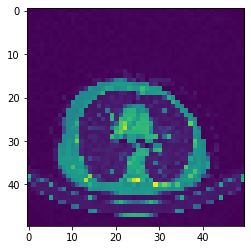

In [ ]:
for batch in my_dataloader:
  tensim = batch[0][0][0]
  plt.imshow(tensim)
  break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(dev)

class MyConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_convolution = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.second_convolution = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2)

        self.pool = nn.MaxPool2d(2, 2)
        # transform dintr o imagine 3D intru un vector de rezultate
        self.flatten = nn.Flatten()

        # fc -> layere neuronale normale
        self.fully_connected1 = nn.Linear(1600, 50)
        self.fully_connected2 = nn.Linear(50, 3)
        # self.fully_connected1 = nn.Linear(1600, 1200)
        # self.fully_connected2 = nn.Linear(1200, 800)
        # self.fully_connected3 = nn.Linear(800, 3)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # to use BatchNorm2D if needed
        # to use dropout on fc
        x = self.first_convolution(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.second_convolution(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        x = self.fully_connected1(x)
        x = self.relu(x)

        x = self.fully_connected2(x)
        x = self.relu(x)
        x = self.softmax(x)

        #x = self.fully_connected3(x)
        #x = self.relu(x)
        #x = self.softmax(x)
        return x

cuda:0


In [ ]:
import torch.optim as optim

In [ ]:
net = MyConvolutionNetwork()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# criterion.to(device)

# this is one epoch, it should be done for more epochs

net.train() # if training mode
# net.eval() # if validation mode
# se antreneaza de 100 de ori pe setul de date
for i in range(0, 100):
  print('epoca' + str(i))
  j = 0
  for batch in my_dataloader:
    # print(batch)
    j += 1
    # print('batch',j)
    torch_image, label = batch
    # torch_image.to(device)
    torch_image = torch_image.cuda()
    # label.to(device)
    label = label.cuda()
    # print('uploaded to gpu')

    optimizer.zero_grad()
    # output = net(torch_image.cuda())
    output = net(torch_image)
    # print('ran net')

    predicted_label = torch.argmax(output, axis=1)
    print("Label: ", label)
    print("Prediction: ", predicted_label)
    # predicted_label.to(device)
    # output este o lista de lista

    # output.to(device)
    # label.to(device)
    # label = label.cuda()
    loss = criterion(output, label)
    # print('calculated loss')

    # just on training -- ac
    loss.backward()
    optimizer.step()
    # print('got gradient')

    #print(loss)
print("Done")

Streaming output truncated to the last 5000 lines.
Label:  tensor([0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0,
        1, 2, 2, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 0, 0], device='cuda:0')
Prediction:  tensor([0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0,
        1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0], device='cuda:0')
Label:  tensor([2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2,
        0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1], device='cuda:0')
Prediction:  tensor([1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2,
        0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1], device='cuda:0')
Label:  tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, 2, 2, 2, 1, 0, 0, 1, 2, 0,
        1, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 0], device='cuda:0')
Prediction:  tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 1, 2, 0,
        1, 1, 1, 0, 2, 1, 0, 0, 1, 2

In [ ]:
# NU RULA
net = MyConvolutionNetwork()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# criterion.to(device)
for layer in net.children():
  if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

# this is one epoch, it should be done for more epochs

net.train() # if training mode
# net.eval() # if validation mode
# se antreneaza de 1000 de ori pe setul de date
for i in range(0, 100):
  print('epoca' + str(i))
  j = 0
  for batch in my_dataloader:
    # print(batch)
    j += 1
    # print('batch',j)
    torch_image, label = batch
    # torch_image.to(device)
    #torch_image = torch_image.cuda()
    # label.to(device)
    label = label.cuda()
    # print('uploaded to gpu')

    optimizer.zero_grad()
    output = net(torch_image.cuda())
    #output = net(torch_image)
    loss = criterion(output, label)
    # print('ran net')
    predicted_label = torch.argmax(output, axis=1)
    if i == 0:
      print("Label: ", label)
      print("Prediction: ", predicted_label)
    #predicted_label.to(device)
    # output este o lista de lista

    #output.to(device)
    #label.to(device)
    # label = label.cuda()

    # print('calculated loss')

    # just on training -- ac
    loss.backward()
    optimizer.step()
    # print('got gradient')

    #print(loss)
print("Done")

epoca0
Label:  tensor([2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 2,
        0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0], device='cuda:0')
Prediction:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Label:  tensor([1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0,
        1, 2, 2, 0, 1, 0, 1, 1, 1, 0, 1, 2, 2, 0, 0, 2], device='cuda:0')
Prediction:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Label:  tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1], device='cuda:0')
Prediction:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Label:

In [ ]:
# import torch
# torch.cuda.is_available

In [ ]:
###### TEST

In [ ]:
df = pd.read_csv("/content/docs/ai-unibuc-23-31-2021/validation.txt", header = None, names = ["path", "label"])
df.head()

,path,label
0,6477e645-3dd.png,1
1,27b8522b-de9.png,2
2,8bbde802-9b3.png,0
3,b29356b6-7da.png,0
4,dbc838be-356.png,2


In [ ]:
validation_images_paths = df.loc[0:4500, "path"].tolist()
validation_images_labels = df.loc[0:4500, "label"].tolist()
validation_images_paths = [os.path.join('/content/docs/ai-unibuc-23-31-2021/validation',path) for path in validation_images_paths]

In [ ]:
len(validation_images_paths)

4500

In [ ]:
validation_tmdataset = TMDataset(validation_images_paths, validation_images_labels)
validation_tmdataset[-1]

(tensor([[[0.0078, 0.0078, 0.0118,  ..., 0.0039, 0.0039, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0118, 0.0078],
          [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.5098, 0.2863, 0.0588,  ..., 0.2118, 0.5216, 0.0353],
          [0.0078, 0.0039, 0.0000,  ..., 0.0078, 0.0078, 0.0157],
          [0.0118, 0.0118, 0.0078,  ..., 0.0118, 0.0078, 0.0078]]]), tensor(2))

In [ ]:
validation_dataloader = DataLoader(validation_tmdataset, batch_size = 128 , shuffle = False, prefetch_factor=4, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
net

MyConvolutionNetwork(
  (first_convolution): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (second_convolution): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fully_connected1): Linear(in_features=1600, out_features=50, bias=True)
  (fully_connected2): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
# Nu cuaie
net.train()
for i in range(1, 100):
  # print('epoca' + str(i))
  j = 0
  for batch in my_dataloader:
    # print(batch)
    j += 1
    # print('batch',j)
    torch_image, label = batch
    # torch_image.to(device)
    torch_image = torch_image.cuda()
    # label.to(device)
    label = label.cuda()
    # print('uploaded to gpu')

    optimizer.zero_grad()
    # output = net(torch_image.cuda())
    output = net(torch_image)
    # print('ran net')

    predicted_label = torch.argmax(output, axis=1)
    #print("Label: ", label)
    #print("Prediction: ", predicted_label)
    # predicted_label.to(device)
    # output este o lista de lista

    # output.to(device)
    # label.to(device)
    # label = label.cuda()
    loss = criterion(output, label)
    # print('calculated loss')

    # just on training -- ac
    loss.backward()
    optimizer.step()
    # print('got gradient')
    print("epoca" + str(i) + " batch " + str(j), loss)
print("Done")

Streaming output truncated to the last 5000 lines.
epoca4 batch 2 tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 3 tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 4 tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 5 tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 6 tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 7 tensor(0.5764, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 8 tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 9 tensor(0.5515, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 10 tensor(0.6197, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 11 tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 12 tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 13 tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)
epoca4 batch 14 tensor(0.5514, device='cuda:0', grad_fn=<

In [ ]:
#net = MyConvolutionNetwork()
#net.to(device)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()
# criterion.to(device)

# this is one epoch, it should be done for more epochs

# net.train() # if training mode
net.eval() # if validation mode
# se antreneaza de 1000 de ori pe setul de date

j = 0
validation_predicted_label = []
for batch in validation_dataloader:
  # print(batch)
  #j += 1
  # print('batch',j)
  torch_image, validation_label = batch
  torch_image = torch_image.to(device)
  # validation_label.to(device)
  # print('uploaded to gpu')
  # validation_label = validation_label.to(device)

  #optimizer.zero_grad()
  # output = net(torch_image.cuda())
  output = net(torch_image)
  # print('ran net')
  #print(torch.argmax(output, axis=1).cpu().numpy())
  validation_predicted_label = np.concatenate((validation_predicted_label, torch.argmax(output, axis=1).cpu().numpy()))
  # validation_predicted_label.to(device)
  # output.to(device)
  # validation_label.to(device)
  # validation_label = validation_label.cuda()
  # print('calculated loss', loss)

  # just on training -- ac
  # loss.backward()
  # optimizer.step()
  # print('got gradient')

  # print(loss)
print("end")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


end


In [ ]:
# import sklearn.metrics.accuracy_score
from sklearn.metrics import accuracy_score
validation_label = validation_predicted_label
print(validation_images_labels)
print(validation_label.shape)
accuracy = accuracy_score(validation_images_labels, validation_label)
print(accuracy)

[1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 2, 2, 2, 1, 0, 2, 

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(validation_images_labels, validation_label)
print(conf_mat)

[[1166  250   84]
 [ 270  704  526]
 [ 160  227 1113]]


In [ ]:
# NU
import copy
zerocincidoi = copy.deepcopy(validation_label)
zerocincidoi2 = copy.deepcopy(validation_images_labels)

In [ ]:
# NU
validation_label[0] = 2
print(validation_label[:10])
print(zerocincidoi[:10])

[2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Nu neaparat
print(validation_label)
print(validation_images_labels)

[2. 0. 0. ... 0. 0. 0.]
[1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 

In [ ]:
import copy
testfile = pd.read_csv("/content/docs/ai-unibuc-23-31-2021/test.txt", header = None, names = ["path"])
testfile.head()

#print(testfile.size)
test_images_paths = testfile.loc[0:3900, "path"].tolist()
test_images_paths_relative = copy.deepcopy(test_images_paths)
#print(test_images_paths[:10])

test_images_paths = [os.path.join('/content/docs/ai-unibuc-23-31-2021/test',path) for path in test_images_paths]
#print(test_images_paths[:10])
#img = Image.open(test_images_paths[0])
#plt.imshow(img)
test_labels = [0] * 3900
testdataset = TMDataset(test_images_paths, test_labels)
testdataset[-1]
testdataloader = DataLoader(testdataset, batch_size = 128 , shuffle = False, prefetch_factor=4, num_workers=4)
test_predicted_label = []
for batch in testdataloader:
  torch_image, validation_label = batch
  torch_image = torch_image.to(device)
  # validation_label.to(device)
  # print('uploaded to gpu')
  # validation_label = validation_label.to(device)

  #optimizer.zero_grad()
  # output = net(torch_image.cuda())
  output = net(torch_image)
  # print('ran net')
  #print(torch.argmax(output, axis=1).cpu().numpy())
  test_predicted_label = np.concatenate((test_predicted_label, torch.argmax(output, axis=1).cpu().numpy()))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for i in range(len(test_predicted_label)):
  print(test_predicted_label[i])

NameError: ignored